In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.functional import softmax
from torch.distributions import uniform, cauchy, normal, relaxed_bernoulli
from scipy.linalg import toeplitz, circulant
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
plt.style.use('ggplot')
import os
import ipdb

In [4]:
hsv = plt.get_cmap('hsv')
ipdb.set_trace()
print('done')

--Return--
None
> <ipython-input-4-7e5557ead4d3>(2)<module>()
      1 hsv = plt.get_cmap('hsv')
----> 2 ipdb.set_trace()
      3 print('done')

ipdb> hsv
ipdb> hsv()
*** TypeError: __call__() missing 1 required positional argument: 'X'
ipdb> hsv[0]
*** TypeError: 'LinearSegmentedColormap' object does not support indexing
ipdb> exit


BdbQuit: 

In [901]:
# Fetch distribution objects for intrinsic frequencies

def get_dist(dist_name,):
    if dist_name == 'cauchy':
        loc = 0.0
        scale = 1.0
        dist = cauchy.Cauchy(loc, scale)
        g0 = torch.exp(dist.log_prob(loc))
        return dist, g0
    elif dist_name == 'uniform':
        high = 1.0
        low = -1.0
        g0 = 1. / (high - low)
        dist = uniform.Uniform(-1.0, 1.0)
        return dist, g0

In [ ]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-1*(x)))

def normalize(x):
    return x / torch.sqrt((x**2).sum((1,2)).unsqueeze(-1).unsqueeze(-1))

In [936]:
class connectivity_net(torch.nn.Module):
    def __init__(self, num_in, num_hid_units=256):
        super(connectivity_net, self).__init__()
        self.num_in = num_in

        self.num_out = int(num_in*(num_in - 1) / 2.)
        self.layers = torch.nn.Sequential(torch.nn.Linear(num_in, num_hid_units),
                         torch.nn.ReLU(),
                         torch.nn.Linear(num_hid_units,self.num_out))
#         self.layers = torch.nn.Linear(num_in,self.num_out)

    def forward(self,x): 
        return self.layers(x)
    
class perm_net(torch.nn.Module):
    def __init__(self, num_in, num_hid_units=256, num_hid_layers=1,transform=None):
        super(perm_net, self).__init__()
        self.transform=transform
        self.layers = torch.nn.ModuleList([torch.nn.Linear(num_in, num_hid_units),
                         torch.nn.ReLU()])
        for _ in range(num_hid_layers):
            self.layers.extend([torch.nn.Linear(num_hid_units, num_hid_units),torch.nn.ReLU()])
        self.layers.append(torch.nn.Linear(num_hid_units,num_in))
    def forward(self,x):   
        for layer in self.layers:
            x = layer(x)
        if self.transform == 'softmax':
            x = softmax(x,dim=-1)
        elif self.transform == 'sigmoid':
            x = sigmoid(x)
        return x
    
class perm_GRU(torch.nn.Module):
    def __init__(self, num_in, num_hid_units=256,num_hid_layers=1, T=10, transform=None):
        super(perm_GRU, self).__init__()
        self.num_hid_units = num_hid_units
        self.num_hid_layers = num_hid_layers
        self.T = T
        self.transform = transform
        
        self.gru = torch.nn.GRU(num_in, num_hid_units, num_hid_layers,)
        self.fc = torch.nn.Linear(self.num_hid_units, num_in)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x, h):
        x = torch.stack([x for _ in range(self.T)])
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[-1, ...]))
        if self.transform == 'softmax':
            out = softmax(out,dim=-1)
        elif self.transform == 'sigmoid':
            out = sigmoid(out)
        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_hid_layers, batch_size, self.num_hid_units).zero_()
        return hidden

In [6]:
def laplacian_spectrum(W, normalized=True):
    D_bar = np.diag(np.abs(W).sum(1))
    L = D_bar - W
    if normalized:
        mask = np.eye(W.shape[0])
        D_bar_sqrt = np.where(mask, D_bar**(-.5), np.zeros_like(D_bar))
        L_sym = np.matmul(D_bar_sqrt, np.matmul(L, D_bar_sqrt))
        return np.linalg.eigvals(L_sym)
    else:
        return np.linalg.eigvals(L)

In [944]:
def get_factors(n):
    factors = []
    for x in range(1, int(np.sqrt(n)) + 1):
        if n % x == 0:
            factors.append((x, n//x))
    return factors

def nearly_square(n):
   factor_pairs = get_factors(n)
   pair_diffs = np.abs([x - y for (x,y) in factor_pairs])
   return factor_pairs[np.argmin(pair_diffs)]

def CosDiff(phases, masks, transform='linear',burn_in_prop=.5, eps=None):
    T = phases.shape[0]
    post_burn_in_steps = T - int(burn_in_prop * T)
    num_groups = masks.shape[1]
    group_size = masks.sum(2)
    num_units  = phases.shape[-1]
    diff_mask  = torch.einsum('tgu,tgv->tguv',masks,masks).bool()
    diff_mask  = torch.where(diff_mask, -1*torch.ones_like(diff_mask.long()), torch.ones_like(diff_mask.long()))
    phase_diffs = diff_mask*torch.cos(phases.unsqueeze(-1) - phases.unsqueeze(-2)) / (num_units * (num_units - 1) / 2)
    loss = phase_diffs.sum((-2,-1)) / group_size
    return loss[-1*post_burn_in_steps:].mean()

def CosDiff_batch(phases, masks, transform='linear',burn_in_prop=.5, eps=None):
    T = phases.shape[0]
    post_burn_in_steps = T - int(burn_in_prop * T)
    num_groups = masks.shape[1]
    group_size = masks.sum(2)
    num_units  = phases.shape[-1]
    diff_mask  = torch.einsum('bgu,bgv->bguv',masks,masks).bool()
    diff_mask  = torch.where(diff_mask, -1*torch.ones_like(diff_mask.long()), torch.ones_like(diff_mask.long()))
    phase_diffs = diff_mask*torch.cos(phases.unsqueeze(-1) - phases.unsqueeze(-2)) / (num_units * (num_units - 1) / 2)
    loss = phase_diffs.sum((-2,-1)) / group_size
    return loss[-1*post_burn_in_steps:].mean()    

def Coherence(phase, mask, transform='mean'):
    groups_size = mask.sum(2)
    if torch.sign(groups_size).sum() < torch.ones_like(groups_size).sum():
        raise ValueError('Some group does not have oscillators at all')
    sin_mean = (mask * torch.sin(phase)).sum(2) / groups_size
    cos_mean = (mask * torch.cos(phase)).sum(2) / groups_size
    if transform is None:
        return 1 - (sin_mean ** 2 + cos_mean ** 2)
    elif transform is 'mean':
        return 1 - (sin_mean ** 2 + cos_mean ** 2).mean(1)
    
def cohn_loss(phases, masks, eps=1e-5, burn_in_prop=.5):
    num_groups = masks.shape[1]
    group_size = masks.sum(2)
    T = phases.shape[0]
    post_burn_in_steps = T - int(burn_in_prop * T)
    masked_phases = phases * masks
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(2))**2 + (yy.sum(2))**2) / group_size
    synch = 1 - go.mean(1)
    
    mean_angles = torch.atan2(yy.sum(2), xx.sum(2))
    phase_diffs = mean_angles.unsqueeze(2) - mean_angles.unsqueeze(1)
    desynch = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + eps))).sum((1,2)) / (num_groups)**2
    desynch -= c_min
    
    loss = .5*(synch + desynch)[-1*post_burn_in_steps:]
    return loss.mean()

def cohn_loss_batch(phases, masks, eps=1e-12, burn_in_prop=.5):
    num_groups = masks.shape[1]
    group_size = masks.sum(2)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    burn_in_steps = int(burn_in_prop * T)
    masked_phases = phases.unsqueeze(2) * masks.unsqueeze(0)
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(2)/num_groups
    mean_angles = torch.atan2(yy.sum(-1), xx.sum(-1))
    phase_diffs = mean_angles.unsqueeze(3) - mean_angles.unsqueeze(2)
    desynch = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + eps))).sum((2,3)) / (num_groups)**2
    desynch -= c_min
    loss = .5*(synch + desynch)[burn_in_steps:,...]
    return loss.mean()

def circular_moments(phases, masks, burn_in_prop=.5):
    num_groups = masks.shape[1]
    group_size = masks.sum(2)
    T = phases.shape[0]
    burn_in_steps = int(burn_in_prop * T)
    masked_phases = phases.unsqueeze(1) * masks
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(2))**2 + (yy.sum(2))**2) / group_size
    synch = 1 - go.mean(1)
    
    mean_angles = torch.atan2(yy.sum(-1), xx.sum(-1))
#     desynch = 0
#     for m in range(num_groups):
#         m+=1
#         K_m = 1 if m < num_groups else -1
#         desynch += (K_m / (2*num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
    desynch = -1 * (2*num_groups * num_groups**2) * (torch.cos(num_groups*mean_angles).sum(-1)**2 + torch.sin(num_groups*mean_angles).sum(-1)**2)
    loss = .5*(synch + desynch)[burn_in_steps:,...]
    return loss.mean(), synch.mean(), desynch.mean()


def circular_moments_batch(phases, masks, burn_in_prop=.5):
    num_groups = masks.shape[1]
    group_size = masks.sum(2)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    burn_in_steps = int(burn_in_prop * T)
    masked_phases = phases.unsqueeze(2) * masks.unsqueeze(0)
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(2)/num_groups
    
    mean_angles = torch.atan2(yy.sum(-1), xx.sum(-1))
    desynch = 0
    
    for m in np.arange(1, int(np.floor(num_groups/2.)) + 1):
        desynch += (1.0 / (2*num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
    loss = .5*(synch + desynch)[burn_in_steps:,...]
    return loss.mean()

def circular_variance(phases):
    num_phases = phases.shape[-1]
    xx = torch.cos(phases)
    yy = torch.sin(phases)
    return (1 - (torch.sqrt(xx.sum(-1)**2 + yy.sum(-1)**2)) / num_phases).mean()

In [355]:
def kuramoto(phases, omega, coupling, steps=50, alpha=.01):
    phase_record = [phases]
    for i in range(steps):
        n = coupling.shape[2]
        delta = alpha *(omega + (torch.bmm(coupling, torch.sin(phases).unsqueeze(2).float()).squeeze(2) * torch.cos(phases) -
                torch.bmm(coupling, torch.cos(phases).unsqueeze(2).float()).squeeze(2) * torch.sin(phases)) / n)
        phases = phases + delta
        phase_record.append(phases)
    return torch.stack(phase_record)

# def kuramoto(phases, omega, coupling, steps=50, alpha=.01):
#     phase_record = [phases]
#     for i in range(steps):
#         n = coupling.shape[2]
#         phase_diffs = torch.sin(phases.unsqueeze(2) - phases.unsqueeze(1))
#         delta = alpha * (omega + (1. / n)*(coupling*phase_diffs).sum(1))
#         phases = phases + delta
#         phase_record.append(phases)
#     return torch.stack(phase_record)

In [9]:
def phase_evol(phases, masks, save_name=None, ax=None, action='display'):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[1]
        annot_bool = [True] * group_num
        colors = {}
        if ax is None:
            fig, ax = plt.subplots()
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = (mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[0][num][i]:
                    ax.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        ax.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num),
                                 horizontalalignment='left', size='x-small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        plt.xlabel('Time')
        plt.ylabel('Phase')
        plt.title('Phase Evolution')
    else:
        for i in range(phases.shape[1]):
            ax.plot(phases[:, i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')
    ax.set_ylim([0,2*np.pi])
    plt.tight_layout()
    if action == 'save':
        plt.savefig(save_name + '.png')
    elif action == 'display':
        plt.show()

In [10]:
def plot_phases(phases):
    fig, ax = plt.subplots()
    patches = []
    patches.append(Circle((0.0,0.0), radius=1.0))
    p = PatchCollection(patches, alpha=0.4)
#     p.set_fill(False)
    ax.add_collection(p)
    x = np.cos(phases)
    y = np.sin(phases)
    ax.scatter(x,y)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    plt.close()
    

In [116]:
def OptimizePhase(phases, masks, LossFunc, iterations=1000, lr=0.01, eps=1e-5):
    phase = torch.tensor(phases, requires_grad=True).float()
    opt = torch.optim.Adam([phase,], lr=lr)
    phase = phase.unsqueeze(0)
    lh = []
    dh = []
    sh = []
    for t in range(iterations):
        opt.zero_grad()
        loss, s, d = LossFunc(phase, masks)
        sh.append(s.detach().numpy())
        dh.append(d.detach().numpy())
        lh.append(loss.detach().numpy())
        loss.backward()
        opt.step()
    final_phase = (phase.squeeze().detach().data.numpy() % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    shp = nearly_square(final_phase.shape[0])
    im = ax1.imshow(final_phase.reshape(shp[0],shp[1]), vmax=2*np.pi, vmin=0, cmap='hsv')
    ax2 = fig.add_subplot(122, polar=True)
    sc = ax2.scatter(final_phase,
                     np.ones_like(final_phase),
                     c = final_phase,
                     vmin=0,
                     vmax=2 * np.pi,
                     cmap='hsv')
    plt.setp(ax2.xaxis.get_majorticklabels(), va="top",
             rotation_mode="anchor", fontsize=8)
    ax2.grid(False)
    ax2.set_yticks([])
    ax2.set_ylim(0, 1.05)
    plt.show()
    plt.close()
    return lh, sh, dh

def OptimizeCoupling(phases, masks, LossFunc, iterations=100,
                     lr=0.1, kura_steps=50, burn_in_prop=.5,alpha=.1, normalized=False):
    gen = torch.Generator()
    gen = gen.manual_seed(1342)
    init_coupling = torch.normal(0, 1, size=(1, osci_num, osci_num),generator=gen,requires_grad=False).float()
    if normalized:
        init_coupling = 5*normalize(init_coupling)
    coupling = Variable(init_coupling.clone(), requires_grad=True)
    lh = []
    opt = torch.optim.Adam([coupling,], lr=lr)
    for t in range(iterations):
        normed_coupling = coupling if not normalized else 5*normalize(coupling)
        init_phase = torch.tensor(phase_list).float().unsqueeze(0)
        omega = torch.zeros_like(init_phase)
        opt.zero_grad()
        phase = kuramoto(init_phase, omega, normed_coupling, steps=kura_steps,alpha=alpha)
        loss = LossFunc(phase, masks, burn_in_prop=burn_in_prop)
        lh.append(loss.detach().numpy())
        loss.backward()
        opt.step()
    test_phase = kuramoto(init_phase, omega, normed_coupling, steps=2*kura_steps, alpha=alpha)
    phase_evol(test_phase.detach().numpy(), masks.data.numpy())

    return lh, normed_coupling.detach().numpy(), init_coupling.detach().numpy()

def OptimizeSymmetricCoupling(phases, masks, LossFunc, iterations=100,
                     lr=0.1, kura_steps=50, burn_in_prop=.5,alpha=.1, normalized=False):
    gen = torch.Generator()
    gen = gen.manual_seed(1342)
    ut_size = int(osci_num * (osci_num - 1) / 2)
    triu_ind = torch.triu_indices(row=osci_num, col=osci_num, offset=1)
    tril_ind = torch.tril_indices(row=osci_num, col=osci_num, offset=1)

    init_ut = torch.normal(0, 1, size=(1, ut_size),generator=gen).float()

    ut = Variable(init_ut.clone(), requires_grad=True)
    omega = torch.zeros(1, osci_num).float()
    lh = []
    opt = torch.optim.Adam([ut,], lr=lr)
    for t in range(iterations):
        coupling = torch.zeros(1,osci_num, osci_num)
        coupling[:,triu_ind[0],triu_ind[1]] = ut
        coupling += coupling.transpose(2,1)
        normed_coupling = coupling if not normalized else 5*normalize(coupling)
        
        init_phase = torch.tensor(phase_list).float().unsqueeze(0)
        opt.zero_grad()
        phase = kuramoto(init_phase, omega, normed_coupling, steps=kura_steps,alpha=alpha)
        loss = LossFunc(phase, masks, burn_in_prop=burn_in_prop)
        lh.append(loss.detach().numpy())
        loss.backward()
        opt.step()
    test_phase = kuramoto(init_phase, omega, normed_coupling, steps=2*kura_steps, alpha=alpha)
    phase_evol(test_phase.detach().numpy(), masks.data.numpy())

    return lh, ut.detach().numpy(), init_ut.detach().numpy()


In [156]:
np.random.seed(0)

num_phases = 32
num_groups = 4
noise = 0
if num_phases % num_groups != 0:
    raise ValueError("Num groups must divide num_phases")

#phase_list = (np.linspace(2*np.pi/num_phases,2*np.pi,num_phases) + noise*np.random.normal(0,.5,num_phases)).tolist()
#print(phase_list)
phase_list = np.random.normal(np.pi,.1,(num_phases,)).tolist()
#phase_list = (np.random.rand(num_phases) * 2 * np.pi).tolist()
#phase_list = (np.ones(num_phases) * np.pi).tolist()

groups = np.zeros((num_groups, num_phases))
for i, g in enumerate(groups):
    g[i *int(num_phases / num_groups): (i+1) * int(num_phases / num_groups)] += 1
    
masks = torch.tensor(groups).unsqueeze(0).float()
osci_num = len(phase_list)



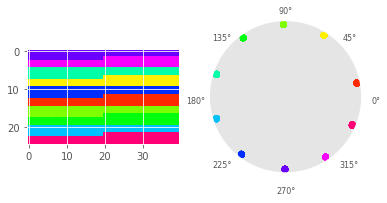

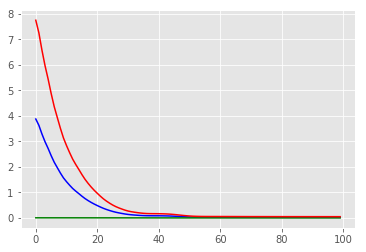

In [103]:
np.random.seed(1)
torch.manual_seed(1)

LossFunc = circular_moments
lh, sh, dh = OptimizePhase(phase_list, masks, LossFunc,iterations=100, lr=.1)

plt.plot(lh, color='b')
plt.plot(sh, color='g')
plt.plot(dh, color='r')
plt.show()
plt.close()

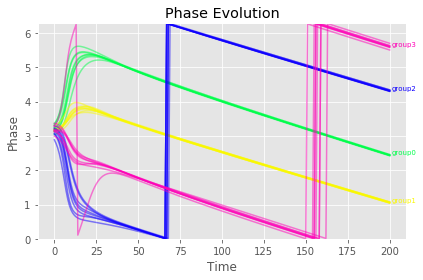

In [138]:
np.random.seed(0)
torch.manual_seed(0)
LossFunc = circular_moments_batch
lh, coupling, init_coupling = OptimizeCoupling(osci_num, masks, LossFunc, lr = 1e-1, iterations=200,
                 kura_steps=100, burn_in_prop=0.0, alpha=.1, normalized=False)

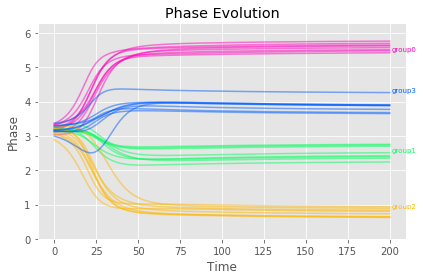

In [186]:
np.random.seed(0)
torch.manual_seed(0)
LossFunc = circular_moments_batch
lh, coupling, init_coupling = OptimizeSymmetricCoupling(osci_num, masks, LossFunc, lr = 1e-1, iterations=100,
                 kura_steps=100, burn_in_prop=.5, alpha=.1, normalized=False)

/home/matt/newtorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  


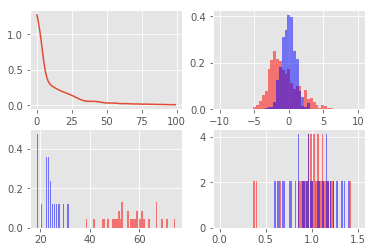

In [187]:
fig, axes = plt.subplots(2,2)

axes[0,0].plot(lh)

bins = np.linspace(-10,10,50)
axes[0,1].hist(coupling.reshape(-1),bins=bins,color='r',alpha=.5, density=True)
axes[0,1].hist(init_coupling.reshape(-1),bins=bins,color='b',alpha=.5, density=True)

bins = np.linspace(0,200,100)
triu_ind = np.triu_indices(osci_num,k=1)
W_opt = np.zeros((osci_num, osci_num))
W_control = np.zeros((osci_num, osci_num))
W_opt[triu_ind[0],triu_ind[1]] = np.squeeze(coupling)
W_control[triu_ind[0],triu_ind[1]] = np.squeeze(init_coupling)
W_opt += W_opt.T
D_bar_opt = np.abs(W_opt).sum(1)
W_control += W_control.T
D_bar_control = np.abs(W_control).sum(1)

axes[1,0].hist(D_bar_opt.reshape(-1),50,color='r',alpha=.5, density=True)
axes[1,0].hist(D_bar_control.reshape(-1),50,color='b',alpha=.5, density=True)
evals_opt     = laplacian_spectrum(W_opt, normalized=True)
evals_control = laplacian_spectrum(W_control, normalized=True)
bins = np.linspace(0.0,1.5,100)
axes[1,1].hist(evals_opt,bins=bins,color='r',alpha=.5, density=True)
axes[1,1].hist(evals_control,bins=bins,color='b',alpha=.5, density=True)
plt.show()
plt.close()

In [925]:
# Compare ordered vs unordered frequencies on a ring
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# Training parameters

omega_name = 'uniform'
num_units = 5
num_groups =5

num_iterations =20
max_sigma=30.0
sigmas= np.linspace(0.0, max_sigma, num_iterations)
O = 1.0
kura_steps = 1000
alpha=1e-2
LossFunc=circular_moments_batch
burn_in_prop = 0.0
mask = torch.stack([torch.eye(num_units) for _ in range(batch_size)])
omega_dist, g0 = get_dist(omega_name)

col = np.zeros(num_units)
col[1::num_units - 2] = -1.0
connectivity = torch.tensor(circulant(col))
connectivity = torch.stack([connectivity for _ in range(batch_size)]).float()
# connectivity[0,-1] = 0
# connectivity[-1,0] = 0
both_lh =[]
both_lh2 = []
for ranked in [True, False]:
    lh = []
    lh2 = []
    for sigma in sigmas:
        omega = O*omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
        if ranked:
            omega, _ = omega.sort(dim=-1)
        init_phase = 2*np.pi * torch.rand((batch_size, num_units))
        phase = kuramoto(init_phase, omega, sigma*connectivity, steps=kura_steps,alpha=alpha)
        loss = LossFunc(phase, mask, burn_in_prop=burn_in_prop)
        loss2 = circular_variance(phase)
        lh.append(loss.mean().detach().numpy())
        lh2.append(loss2.mean().detach().numpy())
    both_lh.append(lh)
    both_lh2.append(lh2)

> <ipython-input-924-ca224fc56705>(109)circular_moments_batch()
    108     ipdb.set_trace()
--> 109     num_groups = masks.shape[1]
    110     group_size = masks.sum(2)

ipdb> l
    104     return loss.mean(), synch.mean(), desynch.mean()
    105 
    106 
    107 def circular_moments_batch(phases, masks, burn_in_prop=.5):
    108     ipdb.set_trace()
--> 109     num_groups = masks.shape[1]
    110     group_size = masks.sum(2)
    111     group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    112     T = phases.shape[0]
    113     burn_in_steps = int(burn_in_prop * T)
    114     masked_phases = phases.unsqueeze(2) * masks.unsqueeze(0)

ipdb> phases.shape
torch.Size([1001, 128, 5])
ipdb> masks.shape
torch.Size([128, 5, 5])
ipdb> exit


BdbQuit: 

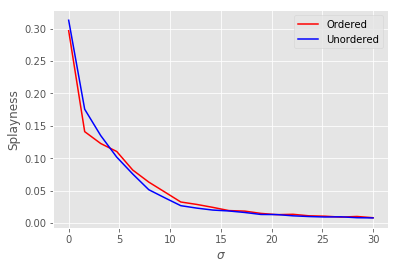

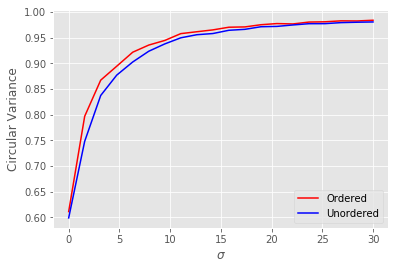

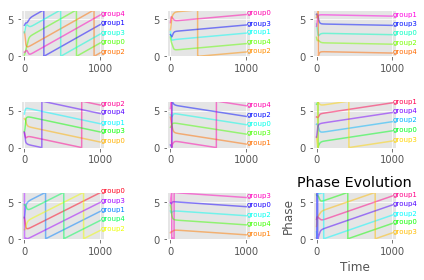

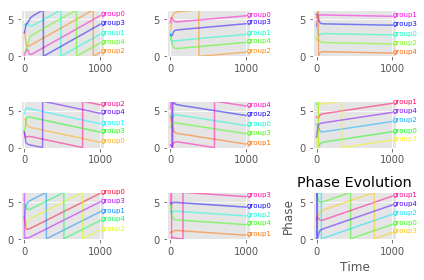

In [916]:
# Display
plt.plot(sigmas, both_lh[0], color='r')
plt.plot(sigmas, both_lh[1], color='b')
plt.ylabel('Splayness')
plt.xlabel(r'$\sigma$')
plt.legend(('Ordered', 'Unordered'))
plt.show()
plt.close()

plt.plot(sigmas, both_lh2[0], color='r')
plt.plot(sigmas, both_lh2[1], color='b')
plt.ylabel('Circular Variance')
plt.xlabel(r'$\sigma$')
plt.legend(('Ordered', 'Unordered'))
plt.show()
plt.close()


omega = O*omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
phase = kuramoto(init_phase, omega, sigmas[-1]*connectivity, steps=kura_steps,alpha=alpha)
ordered_omega, _ = omega.sort(-1)
ordered_phase = kuramoto(init_phase, ordered_omega, sigmas[-1]*connectivity, steps=kura_steps,alpha=alpha)

fig, axes = plt.subplots(3,3)
for a, ax in enumerate(axes.reshape(-1)):
    phase_evol(phase[:,a,...].unsqueeze(1).detach().numpy(), mask[a,...].unsqueeze(0).data.numpy(), ax=ax, action=None)
plt.show()
plt.close()

fig, axes = plt.subplots(3,3)
for a, ax in enumerate(axes.reshape(-1)):
    phase_evol(ordered_phase[:,a,...].unsqueeze(1).detach().numpy(), mask[a,...].unsqueeze(0).data.numpy(), ax=ax, action=None)
plt.show()
plt.close()

In [939]:
# Optimize coupling function
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

# Training parameters

# [.98, .54, .87]

omega_name = 'uniform'
num_units = 17
num_groups =17

# sigma_star = 25.0
num_iterations = 200
# sigma_stars= np.linspace(0.0, max_sigma, num_iterations)
sigma_star = 20.0
O = 5.0
kura_steps = 1000
alpha=1e-2
num_hid_units=1024
num_hid_layers = 3
batch_size = 128
lr = 1e-3
# LossFunc=circular_moments_batch
LossFunc=circular_variance
transform= None
recurrent = True
T=10

burn_in_prop = .5
mask = torch.stack([torch.eye(num_units) for _ in range(batch_size)])

# Training Loop
omega_dist, g0 = get_dist(omega_name)

lh = []
if recurrent:
    pn = perm_GRU(num_units, num_hid_units=num_hid_units, num_hid_layers = num_hid_layers, transform=transform, T=T)
else:   
    pn = perm_net(num_units, num_hid_units=num_hid_units, num_hid_layers = num_hid_layers, transform=transform)
opt = torch.optim.Adam(pn.parameters(),lr=lr)
triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
col = np.zeros(num_units)
col[1::num_units - 2] = -1.0
connectivity = torch.tensor(circulant(col))
connectivity = torch.stack([connectivity for _ in range(batch_size)]).float()

for i in range(num_iterations):
#     sigma_star = sigma_stars[i]
    opt.zero_grad()
    omega = O*omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))

    if recurrent:
        h = pn.init_hidden(batch_size)
        soft_ranked = pn(omega, h)
    else:
        soft_ranked = pn(omega)
    _, hard_inds = soft_ranked.sort(dim=-1)
    hard_ranked = torch.zeros((batch_size, num_units)).scatter_(-1, hard_inds, omega)
    new_omega = hard_ranked - soft_ranked.detach() + soft_ranked
    init_phase = np.pi * torch.ones((batch_size, num_units))
    phase = kuramoto(init_phase, new_omega, sigma_star*connectivity, steps=kura_steps,alpha=alpha)
    loss = LossFunc(phase, mask, burn_in_prop=burn_in_prop)
    lh.append(loss.mean().detach().numpy())
    loss.backward()
    opt.step()


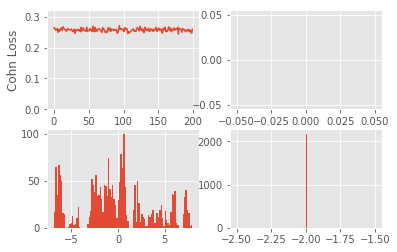

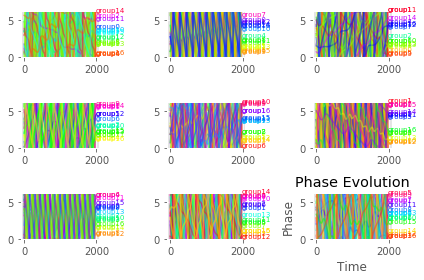

In [940]:
# Display
# omega = O*omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
init_phase = 2*np.pi*torch.rand((batch_size, num_units))
phase = kuramoto(init_phase, omega, sigma_star*connectivity, steps=ks,alpha=alpha)
shuffled_phase = kuramoto(init_phase, omega, sigma_star*connectivity[torch.randperm(batch_size),...], steps=ks,alpha=alpha)
fig, axes = plt.subplots(2,2)

axes[0,0].plot(lh)
axes[0,0].set_ylim([0.0, np.max(lh) + .05])
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Cohn Loss')

axes[0,1].plot(ph)

axes[1,0].hist(soft_ranked.reshape(-1).detach().numpy(),100)
axes[1,1].hist(connectivity.sum(1).reshape(-1).detach().numpy(),100)

plt.show()
plt.close()

# fig, axes = plt.subplots(3,3)
# for a,ax in enumerate(axes.reshape(-1)):
#     ax.imshow(connectivity[a,...].detach().numpy())
# plt.show()
# plt.close()

fig, axes = plt.subplots(3,3)
for a, ax in enumerate(axes.reshape(-1)):
    phase_evol(phase[:,a,...].unsqueeze(1).detach().numpy(), mask[a,...].unsqueeze(0).data.numpy(), ax=ax, action=None)
plt.show()
plt.close()

# fig, axes = plt.subplots(3,3)
# for a, ax in enumerate(axes.reshape(-1)):
#     phase_evol(shuffled_phase[:,a,...].unsqueeze(1).detach().numpy(), mask[a,...].unsqueeze(0).data.numpy(), ax=ax, action=None)
# plt.show()
# plt.close()


In [767]:
ranked_splay_line = lh

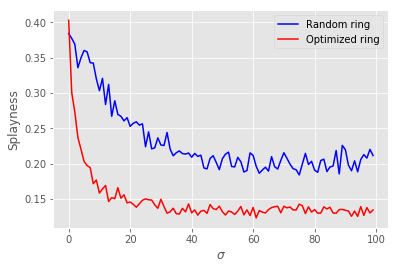

In [943]:
plt.plot(unranked_splay, color='b')
plt.plot(ranked_splay, color='r')
plt.xlabel(r'$\sigma$')
plt.ylabel('Splayness')
plt.legend(('Random ring', 'Optimized ring'))
plt.show()
plt.close()